# TP OpenMP - October 2022

Florian Rascoussier

Bastien Barbe

Ce notebook constitue une étude comparative des méthodes de parallélisation CUDA sur GPU pour différentes applications.

## Part 2 : Matrix-Vector operation

Ce programme fait du calcul vectoriel sur des matrices et des vecteurs.
### Compilation

In [1]:
# script params
EXEC: bool = True

In [7]:
# create /bin if it does not exist
!mkdir -p bin

# compile the programs
!nvcc -o bin/tp_cuda_part_2_vector_sequential tp_cuda_part_2_vector_sequential.cu -O3
!nvcc -o bin/tp_cuda_part_2_vector_1_thread_per_1_block tp_cuda_part_2_vector_1_thread_per_1_block.cu -O3
!nvcc -o bin/tp_cuda_part_2_vector_multithread_atomics tp_cuda_part_2_vector_multithread_atomics.cu -O3
!nvcc -o bin/tp_cuda_part_2_vector_multithread_shared_atomics tp_cuda_part_2_vector_multithread_shared_atomics.cu -O3 -g

# cuda-memcheck ./bin/tp_cuda_part_1_pi_basic -T 1000 -N 100000

Testing with S=31, out of memory as it requires more than 2 Go of device memory

### Performance evaluation

In [19]:
# global vars
csv_result_file = "stats.csv"
csv_headers = {
    'version': str,
    'S': int,
    'T': int,
    'runtime' : float
}

N_values = [2, 4, 8, 10, 12, 14]
M_values = [1, 3, 7, 9, 11, 13]
T_values = [1, 32, 64, 128, 256]

S_values = []
for N in N_values:
    for M in M_values:
        S_values.append(2**(N+M))
S_values = list(set(S_values))
S_values = sorted(S_values)

print("S values:", S_values)

program_classes = {
    "sequential": "purple",
    "onethreadperblock": "red",
    "multithread_atomics": "orange",
    "multithread_shared": "blue"
}

S_classes = {
    8: "purple",
    32: "red",
    128: "orange",
    512: "blue",
    2048: "green",
    8192: "brown",
    32768: "pink",
    131072: "gray",
    524288: "olive",
    2097152: "cyan",
    8388608: "magenta",
    33554432: "lime",
    134217728: "black"
}
    

repeats = 10

S values: [8, 32, 128, 512, 2048, 8192, 32768, 131072, 524288, 2097152, 8388608, 33554432, 134217728]


In [10]:
import os
import subprocess

def delete_old_csv_file():
    try:
        os.remove(csv_result_file)
    except OSError:
        pass

def create_csv_file():
    print(f"Creating NEW CSV file ({csv_result_file})")
    f = open(csv_result_file, "w")
    f.write(",".join(csv_headers.keys()) + "\n")
    f.close()

# execute the programs
def run_program(
    program_filepath: str, N: int, M: int, T: int
):
    S: int = N + M
    args = (program_filepath, 
        "-N", str(N), 
        "-M", str(M),
        "-S", str(S),
        "-T", str(T),
    )
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()

print("Program executions")
def exec_instances():
    for N in N_values:
        for M in M_values:
            for T in T_values:
                print(f" + Running programs (N: {N}, M: {M}) with T: {T}")
                for _ in range(repeats):
                    run_program("bin/tp_cuda_part_2_vector_sequential", N,M,T)
                    run_program("bin/tp_cuda_part_2_vector_1_thread_per_1_block", N,M,T)
                    run_program("bin/tp_cuda_part_2_vector_multithread_atomics", N,M,T)
                    run_program("bin/tp_cuda_part_2_vector_multithread_shared_atomics", N,M,T)
                    print("*", end = '')
                print()

if EXEC:
    delete_old_csv_file()
    create_csv_file()
    exec_instances()
else: 
    print(f"WARN: EXEC = {EXEC}. No C++ program execution.")



Program executions
Creating NEW CSV file (stats.csv)
 + Running programs (N: 2, M: 1) with T: 1
**********
 + Running programs (N: 2, M: 1) with T: 32
**********
 + Running programs (N: 2, M: 1) with T: 64
**********
 + Running programs (N: 2, M: 1) with T: 128
**********
 + Running programs (N: 2, M: 1) with T: 256
**********
 + Running programs (N: 2, M: 3) with T: 1
**********
 + Running programs (N: 2, M: 3) with T: 32
**********
 + Running programs (N: 2, M: 3) with T: 64
**********
 + Running programs (N: 2, M: 3) with T: 128
**********
 + Running programs (N: 2, M: 3) with T: 256
**********
 + Running programs (N: 2, M: 7) with T: 1
**********
 + Running programs (N: 2, M: 7) with T: 32
**********
 + Running programs (N: 2, M: 7) with T: 64
**********
 + Running programs (N: 2, M: 7) with T: 128
**********
 + Running programs (N: 2, M: 7) with T: 256
**********
 + Running programs (N: 2, M: 9) with T: 1
**********
 + Running programs (N: 2, M: 9) with T: 32
**********
 + Running

### Performance analysis

,version,S,T,runtime
0,sequential,8,1,0.000001
1,onethreadperblock,8,1,0.000178
2,multithread_atomics,8,1,0.000179
3,multithread_shared,8,1,0.000176
4,sequential,8,1,0.000001
5,onethreadperblock,8,1,0.000149
6,multithread_atomics,8,1,0.000165
7,multithread_shared,8,1,0.000162
8,sequential,8,1,0.000001
9,onethreadperblock,8,1,0.000164


y_axis_first (4.879490112161606e-07, 3.5005534404973275)
type y_axis_first <class 'tuple'>


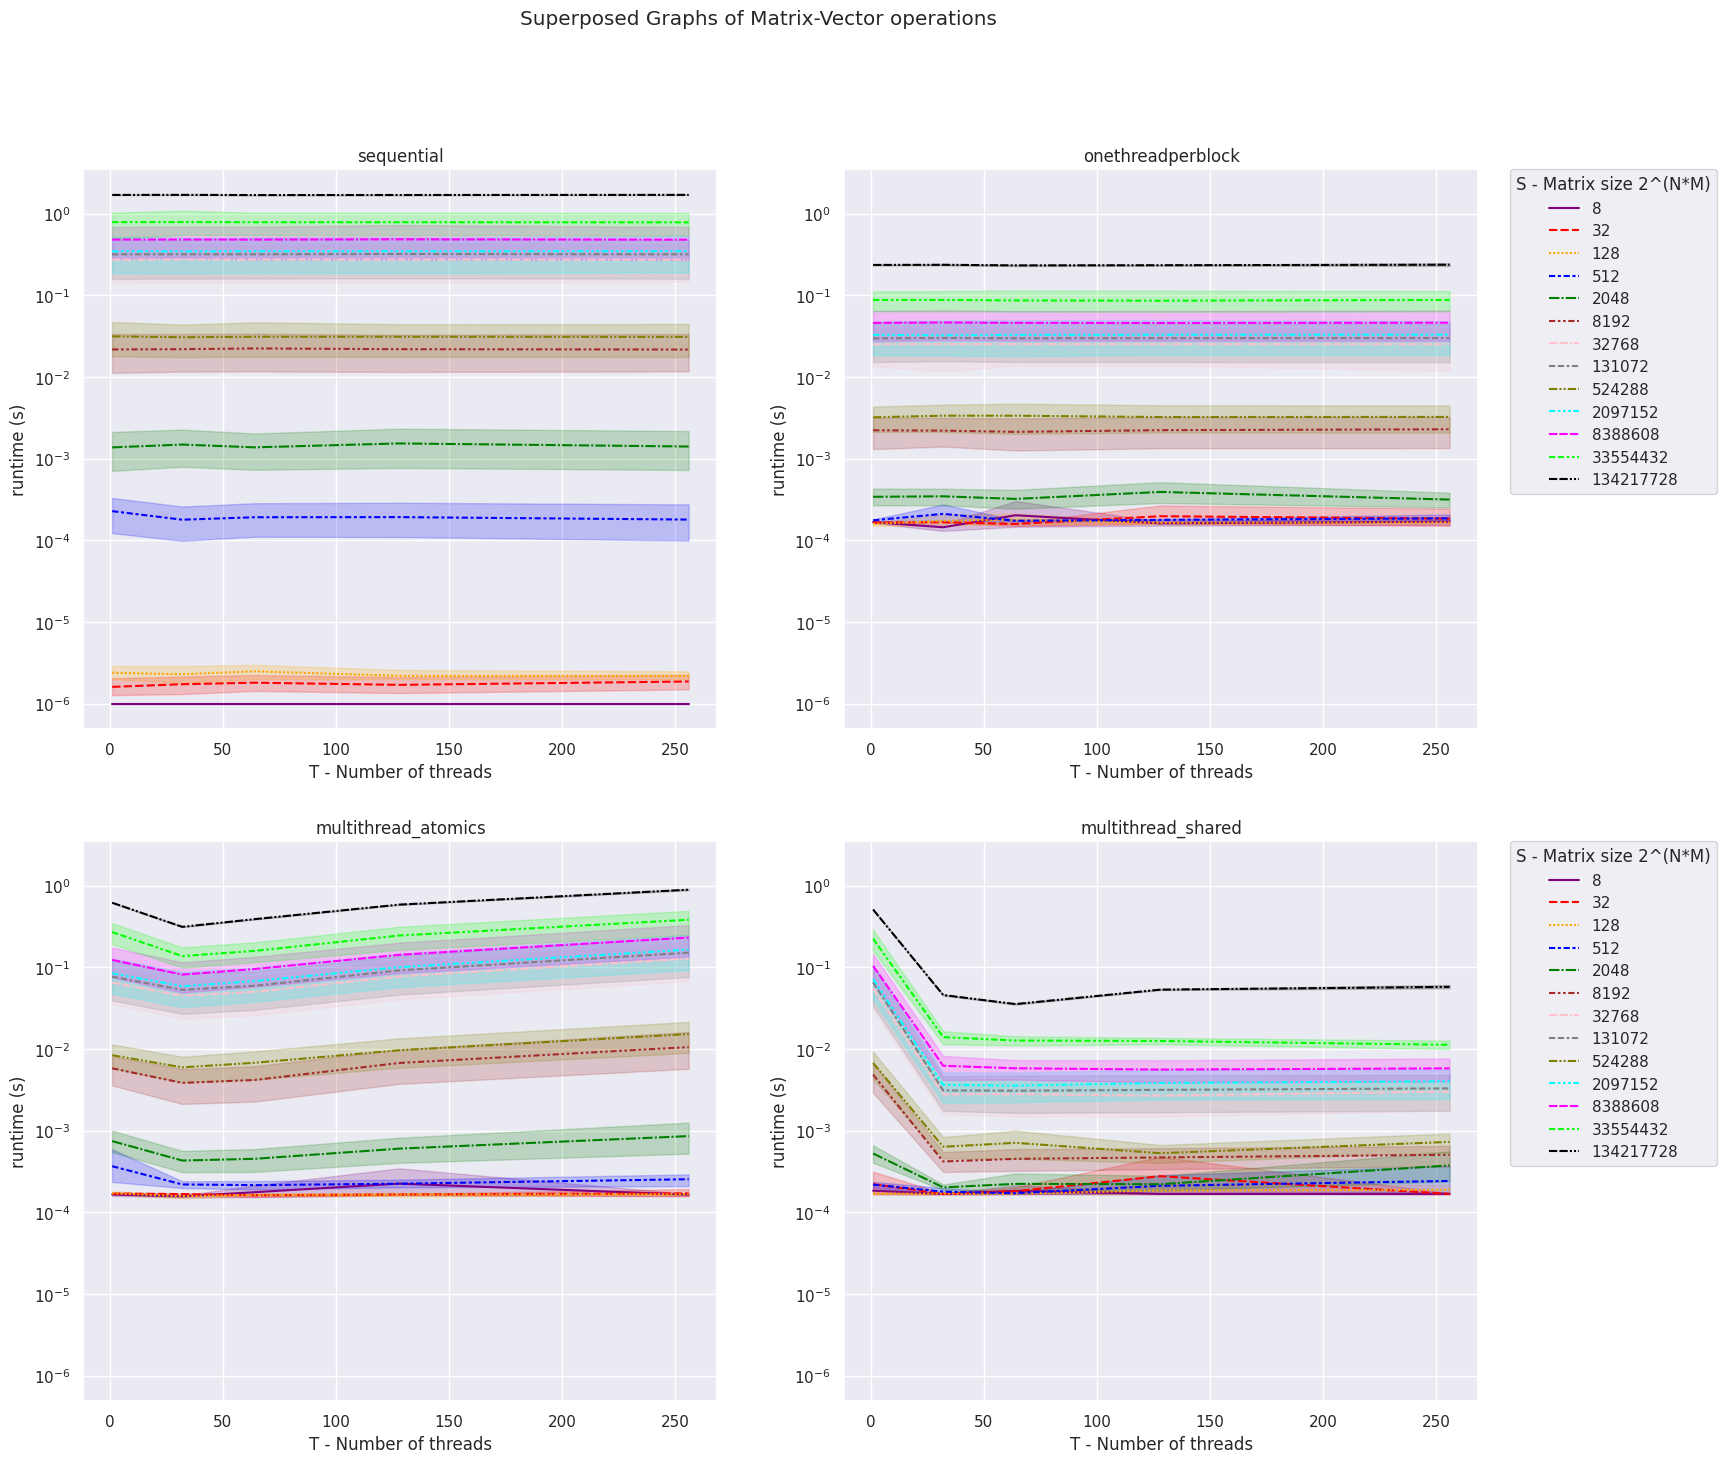

In [43]:
# superposed big graph
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from numpy import genfromtxt
import pandas as pd
import seaborn as sns

sns.set()


df = pd.read_csv(
    csv_result_file,
    header=0, # line number of header
    dtype=csv_headers
)
display(df.head(10))

# filter out 0 runtime values
df = df[df.runtime > 0]



# display the graph
def display_graph(df: pd.DataFrame):
    COLUMNS = 2
    ROWS = 2

    fig, ax = plt.subplots(COLUMNS, ROWS, figsize=(18,16))
    fig.suptitle(f"Superposed Graphs of Matrix-Vector operations")

    y_axis_first = None
    for i in range(ROWS):
        for j in range(COLUMNS):
            # print version graph data
            graph_version = list(program_classes.keys())[i*COLUMNS + j]
            df_plot_0 = df[df['version'] == graph_version]

            g0 = sns.lineplot(
                ax=ax[i][j],
                data=df_plot_0, 
                x="T",
                y="runtime", 
                hue="S",
                palette=S_classes,
                style="S",
            )
            g0.set(title=graph_version)
            g0.set(yscale="log")
            g0.set(xlabel="T - Number of threads", ylabel="runtime (s)")

            # set y axis to the same scale
            
            if i == 0 and j == 0:
                y_axis_first = g0.get_ylim()
                print("y_axis_first", y_axis_first)
                print("type y_axis_first", type(y_axis_first))
            else:
                g0.set_ylim(y_axis_first)

            # add legend on right side
            if j == 1:
                g0.legend(
                    loc='upper left', 
                    bbox_to_anchor=(1.05, 1), 
                    borderaxespad=0., 
                    title="S - Matrix size 2^(N*M)"
                )
            else:
                g0.legend().set_visible(False)
            
            # g00 = sns.scatterplot(
            #     ax=ax[i][j],
            #     data=df_plot_0, 
            #     x="T",
            #     y="runtime", 
            #     hue="S",
            #     palette=S_classes, 
            #     legend=False, 
            # )
            # g00.set(yscale="log")

    # display the graphs
    plt.show()


display_graph(df)

### Discussion

Pour le graphique du programme `sequential`, on observe comme attendu que le temps de calcul ne dépends pas du nombre de threads. En effet, ce code n'utilise tout simplement pas le GPU. Ce programme reste tout de même le plus efficace pour un petit nombre de calculs (Matrices et vecteurs de petites tailles) (S<=128).

Pour le programme `onethreadperblock`, on observe de même aucune amélioration des résultats en augmentant le nombre de threads. C'est un résultat attendu puisque comme son nom l'indique, le programme n'utilise en réalité qu'un seul thread par bloc. Il est moins bon pour un petit nombre de calculs que la version séquentielle, mais meilleur qu'elle pour un grand nombre de calculs (S>=2048).

Pour le programme `multithread_atomics`, on observe une amélioration des temps de calculs pour T=32, mais qui se dégradent en augmentant le nombre de threads par blocs. Il s'avère être pire que `onethreadperblock`, probablement du fait des races-conditions.

Pour le programme `multithread_shared`, on observe une amélioration des temps de calculs pour T=32 et T=64 puis qui se dégrade (S=134217728), ou se maintient (le reste). C'est probablement le programme le plus intéressant quand on cherche de la performance avec de grandes valeurs de S (S>128).

### Interprétation
Le programme purement séquentiel sur CPU est le plus rapide pour S<=128. Ensuite, pour S>128, il devient plus intéressant de paralléliser le programme sur GPU. La version `multithread_shared` en est la meilleure implémentation, car elle combine mémoire partagée et réduction. On note que pour maximiser l'efficacité, il est conseillé d'utiliser entre 64 et 32 threads pour la taille des instances du problème ici considéré.

On peut supposer que le nombre de threads optimal correspond à entre deux entre le nombre de threads par bloc et la taille du problème. Si le nombre de threads par bloc est trop élevé par rapport à la taille de ligne de la matrice A, c'est-à-dire la taille du problème, chaque thread va exécuter un petit nombre d'instructions. Ce qui induit un temps de calcul plus variable par thread que s'ils devaient exécuter un grand nombre de calculs. Ainsi le temps d'attente entre chaque barrière de synchronisation est plus élevé, ce qui explique la dégradation des performances pour T > 64. Il est important de noter que pour une taille de problème plus importante le nombre de threads par bloc optimal va augmenter pour garder un ratio nombre de threads / taille du calcul optimal.